Resources:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from clean_images import ImageClense
from clean_tabular import TabularCleanse

tabular_cleanse = TabularCleanse('fb_marketplace_conn.json', 'aicore2022!')
links =  pd.read_csv('/home/adamw/Documents/AiCore/fb_marketplace/images_fb/Links.csv')

Prepare list of products to include in classficiation
###### This is based on the same data included in the tabular classification

In [29]:
products = pd.read_pickle('final_cleaned_products.pkl')
products = products.dropna(subset='long')
products = tabular_cleanse.remove_rows_conditonal(products, 'price_gbp', 1000.00, '<')
products.drop(['location'], axis=1, inplace=True)
# Drop the cat0 fields to test the model
# Consider that dummy encodign has been applied and therefore on of the clasesses is missing.
# https://machinelearningmastery.com/types-of-classification-in-machine-learning/
#https://machinelearningmastery.com/discrete-probability-distributions-for-machine-learning/
products = products[products.columns.drop(list(products.filter(regex='cat_1')))]
# This puts category appliances back in as it was removed when cleaning the data using dummy encoding. This was used because i did not want to run the geocoder again due to un time.
categories = list(products.filter(regex='cat_0'))
products['cat_0__Appliances'] = np.where(products[categories].sum(axis=1) == 0, 1, 0)
Applicances = products.pop('cat_0__Appliances')
products.insert(4,'cat_0__Appliances', Applicances)
# k-Nearest Neighbors.
# Decision Trees.
# Naive Bayes.
# Random Forest.
# Gradient Boosting.
products.sum()

id                                          243809c0-9cfc-4486-ad12-3b7a16605ba91c58d3f9-8...
price_gbp                                                                            736256.0
long                                                                            344014.976773
lat                                                                             -22414.651779
cat_0__Appliances                                                                         494
cat_0__Baby & Kids Stuff                                                                  392
cat_0__Clothes, Footwear & Accessories                                                    368
cat_0__Computers & Software                                                               547
cat_0__DIY Tools & Materials                                                              505
cat_0__Health & Beauty                                                                    566
cat_0__Home & Garden                                        

Prepare the tabular data for this model

In [6]:
cleanse = TabularCleanse('fb_marketplace_conn.json', 'aicore2022!')
products = cleanse.get_data_table('products')
# cleanse.data_profile_report(products, 'products.html')
cleaning_products = cleanse.remove_rows_conditonal(products, 'category', 'N/A', '!=')
cleaning_products = cleanse.split_df_value(cleaning_products, 'location', ',', ['local_area', 'city'])
cleaning_products = cleanse.convert_str_float(cleaning_products, 'price_gbp', 'price', '[\£,]')
cleaning_products = cleanse.remove_rows_conditonal(cleaning_products, 'price_gbp', 1000.00, '<')
cleaning_products = cleanse.dynamic_split_df_value(cleaning_products, 'category', '/', True, 'sub_cat_')
cleaning_products = cleanse.manual_split_df_value(cleaning_products, 'product_name', 'product_name', '|', 1)
cleaning_products = cleaning_products.dropna(subset=['city'])
cleaning_products.drop(['product_name', 'product_description', 'price', 'create_time', 'category', 'local_area','sub_cat_1','sub_cat_2', 'sub_cat_3', 'sub_cat_4', 'page_id', 'city'], axis=1, inplace=True)

cleaning_products

/home/adamw/Documents/AiCore/fb_marketplace/clean_tabular.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[new_field_names] = data[field_to_split].str.split(split_by, expand=True)
/home/adamw/Documents/AiCore/fb_marketplace/clean_tabular.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[new_field_names] = data[field_to_split].str.split(split_by, expand=True)
/home/adamw/Documents/AiCore/fb_marketplace/clean_tabular.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

,id,location,price_gbp,sub_cat_0
1,243809c0-9cfc-4486-ad12-3b7a16605ba9,"Wokingham, Berkshire",5.0,Home & Garden
2,1c58d3f9-8b93-47ea-9415-204fcc2a22e6,"Inverness, Highland",20.0,Home & Garden
3,860673f1-57f6-47ba-8d2f-13f9e05b8f9a,"Skegness, Lincolnshire",20.0,Home & Garden
4,59948726-29be-4b35-ade5-bb2fd7331856,"Radstock, Somerset",115.0,Home & Garden
5,16dbc860-696e-4cda-93f6-4dd4926573fb,"Delph, Manchester",450.0,Home & Garden
...,...,...,...,...
8085,c4148656-78a9-4f3e-b393-134fdc5ef900,"Acocks Green, West Midlands",260.0,Video Games & Consoles
8086,564e3411-768d-4250-a624-b119d696f103,"Acocks Green, West Midlands",235.0,Video Games & Consoles
8088,2b0a652b-46a2-4297-b619-5efeeb222787,"Montrose, Angus",250.0,Video Games & Consoles
8089,719fd40a-870e-4144-b324-55dff2e66fb4,"Carrickfergus, County Antrim",30.0,Video Games & Consoles


In [7]:
# Using groupby() and count()
df2 = cleaning_products.groupby(['sub_cat_0'])['sub_cat_0'].count()
print(df2)

sub_cat_0
Appliances                           494
Baby & Kids Stuff                    392
Clothes, Footwear & Accessories      368
Computers & Software                 547
DIY Tools & Materials                505
Health & Beauty                      566
Home & Garden                        799
Music, Films, Books & Games          590
Office Furniture & Equipment         542
Other Goods                          494
Phones, Mobile Phones & Telecoms     400
Sports, Leisure & Travel             431
Video Games & Consoles               500
Name: sub_cat_0, dtype: int64


Drop more outliers for testing

In [2]:
from clean_tabular import TabularCleanse
cleanse = TabularCleanse('fb_marketplace_conn.json', 'aicore2022!')
products = cleanse.remove_rows_conditonal(products, 'price_gbp', 1000.00, '<')
products

,id,price_gbp,long,lat,cat_0__Baby & Kids Stuff,"cat_0__Clothes, Footwear & Accessories",cat_0__Computers & Software,cat_0__DIY Tools & Materials,cat_0__Health & Beauty,cat_0__Home & Garden,...,cat_1__ Washer Dryers,cat_1__ Washing Machines,cat_1__ Watches,cat_1__ Water Sports,cat_1__ Wedding Clothes & Accessories,cat_1__ Winter Sports,cat_1__ Women's Accessories,cat_1__ Women's Clothing,cat_1__ Women's Shoes,cat_1__ Wood & Timber
0,243809c0-9cfc-4486-ad12-3b7a16605ba9,5.0,51.453489,-1.031873,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1c58d3f9-8b93-47ea-9415-204fcc2a22e6,20.0,57.479012,-4.225739,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,860673f1-57f6-47ba-8d2f-13f9e05b8f9a,20.0,53.150228,0.329093,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,59948726-29be-4b35-ade5-bb2fd7331856,115.0,51.291949,-2.447623,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,16dbc860-696e-4cda-93f6-4dd4926573fb,450.0,53.568355,-2.026164,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7049,06d8a5c3-4f22-4d1b-ae7e-6ded471eb775,550.0,53.453547,-2.734323,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7050,cce6d412-bac0-489e-9fba-cfdeeb756117,69.0,53.450693,-2.994883,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7051,88d2d66b-2685-46b8-af84-f495fd2ccb14,380.0,53.450693,-2.994883,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7052,8ca91ce8-49e7-4746-b06c-ac838d94ef35,650.0,53.485152,-2.898906,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


                                        id       long       lat
0     243809c0-9cfc-4486-ad12-3b7a16605ba9  51.453489 -1.031873
1     1c58d3f9-8b93-47ea-9415-204fcc2a22e6  57.479012 -4.225739
2     860673f1-57f6-47ba-8d2f-13f9e05b8f9a  53.150228  0.329093
3     59948726-29be-4b35-ade5-bb2fd7331856  51.291949 -2.447623
4     16dbc860-696e-4cda-93f6-4dd4926573fb  53.568355 -2.026164
...                                    ...        ...       ...
7049  06d8a5c3-4f22-4d1b-ae7e-6ded471eb775  53.453547 -2.734323
7050  cce6d412-bac0-489e-9fba-cfdeeb756117  53.450693 -2.994883
7051  88d2d66b-2685-46b8-af84-f495fd2ccb14  53.450693 -2.994883
7052  8ca91ce8-49e7-4746-b06c-ac838d94ef35  53.485152 -2.898906
7053  df8ef910-03cc-4c9e-97a9-7f0a7e838102  51.272337 -0.721647

[6898 rows x 3 columns]


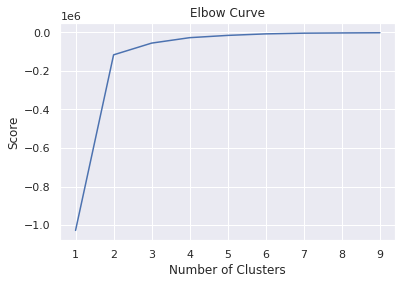

In [48]:
cluster_X = products.loc[:,['id', 'long', 'lat']]
print(cluster_X)

K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = products[['lat']]
X_axis = products[['long']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

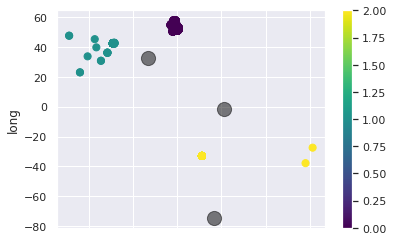

In [49]:
kmeans = KMeans(n_clusters = 3, init ='k-means++')
kmeans.fit(cluster_X[cluster_X.columns[1:3]]) # Compute k-means clustering.
cluster_X['cluster_long_lat'] = kmeans.fit_predict(cluster_X[cluster_X.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(cluster_X[cluster_X.columns[1:3]]) # Labels of each point

cluster_X.plot.scatter(x = 'lat', y = 'long', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
cluster_X = cluster_X.drop(['long', 'lat'], axis=1)


In [50]:
products_clustered = products.merge(cluster_X, left_on='id', right_on='id')
products_clustered = products_clustered.drop(['long', 'lat'], axis=1)
products_clustered

,id,price_gbp,cat_0__Baby & Kids Stuff,"cat_0__Clothes, Footwear & Accessories",cat_0__Computers & Software,cat_0__DIY Tools & Materials,cat_0__Health & Beauty,cat_0__Home & Garden,"cat_0__Music, Films, Books & Games",cat_0__Office Furniture & Equipment,...,cat_1__ Washing Machines,cat_1__ Watches,cat_1__ Water Sports,cat_1__ Wedding Clothes & Accessories,cat_1__ Winter Sports,cat_1__ Women's Accessories,cat_1__ Women's Clothing,cat_1__ Women's Shoes,cat_1__ Wood & Timber,cluster_long_lat
0,243809c0-9cfc-4486-ad12-3b7a16605ba9,5.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1c58d3f9-8b93-47ea-9415-204fcc2a22e6,20.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,860673f1-57f6-47ba-8d2f-13f9e05b8f9a,20.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,59948726-29be-4b35-ade5-bb2fd7331856,115.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,16dbc860-696e-4cda-93f6-4dd4926573fb,450.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6893,06d8a5c3-4f22-4d1b-ae7e-6ded471eb775,550.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6894,cce6d412-bac0-489e-9fba-cfdeeb756117,69.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6895,88d2d66b-2685-46b8-af84-f495fd2ccb14,380.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6896,8ca91ce8-49e7-4746-b06c-ac838d94ef35,650.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
products_clustered = products_clustered.drop(['id'], axis=1)


X = products_clustered.drop(['price_gbp'], axis=1)
y = products_clustered['price_gbp']
X

KeyError: "['id'] not found in axis"

In [5]:
products = products.drop(['id'], axis=1)


X = products.drop(['price_gbp'], axis=1)
y = products['price_gbp']
X

,long,lat,cat_0__Baby & Kids Stuff,"cat_0__Clothes, Footwear & Accessories",cat_0__Computers & Software,cat_0__DIY Tools & Materials,cat_0__Health & Beauty,cat_0__Home & Garden,"cat_0__Music, Films, Books & Games",cat_0__Office Furniture & Equipment,...,cat_1__ Washer Dryers,cat_1__ Washing Machines,cat_1__ Watches,cat_1__ Water Sports,cat_1__ Wedding Clothes & Accessories,cat_1__ Winter Sports,cat_1__ Women's Accessories,cat_1__ Women's Clothing,cat_1__ Women's Shoes,cat_1__ Wood & Timber
0,51.453489,-1.031873,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,57.479012,-4.225739,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,53.150228,0.329093,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,51.291949,-2.447623,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,53.568355,-2.026164,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7049,53.453547,-2.734323,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7050,53.450693,-2.994883,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7051,53.450693,-2.994883,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7052,53.485152,-2.898906,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV


lin = LinearRegression()
# svr = SVR()
lasso = Lasso(alpha=0.01, max_iter=100, selection='random')
# elas = ElasticNet()
dt = DecisionTreeRegressor(max_depth=5, max_features='auto', max_leaf_nodes=20,
                      min_samples_leaf=8, min_weight_fraction_leaf=0.1)
knn = KNeighborsRegressor(algorithm='kd_tree', leaf_size=10, n_neighbors=35, p=1)
gbr = GradientBoostingRegressor(learning_rate=0.01, max_depth=6, n_estimators=500,
                          subsample=0.5)
# sgd = SGDRegressor()
# ker = KernelRidge()
# bayes = BayesianRidge()

regressor_dict = {
    'Linear' : [lin],
    'Lasso' : [lasso],
    'DecisionTree' : [dt],
    'KNeighbours' : [knn],
    'GradientBoost' : [gbr],
}
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.flatten()})
# print(df.head())
# print(np.mean(y_test))


# save model weights
# joblib.dump(lin_regression, "linear_regression.joblib")

Hyperparamater tuning

In [60]:
# create scaler
scaler = StandardScaler()
# fit scaler to train set - which means it identifies the values for scaling only on the training set and stores this in the scaler
scaler.fit(X_train)
# The scaler can now be applied to the train, validation and test sets which holds the info from the train set only
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## knn

In [ ]:
from sklearn.model_selection import GridSearchCV

grid_knn = {
    'n_neighbors': [5, 35],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30],
    'p': [1, 2]
    }

gs = GridSearchCV(
    knn, 
    grid_knn, 
    cv=5,
    verbose=2
    )

gs.fit(X_train, y_train)
gs.best_estimator_


## Lasso

In [ ]:
# Must scale the independent varibles for a regularisation model like this.
# https://towardsdatascience.com/hyperparameter-tuning-in-lasso-and-ridge-regressions-70a4b158ae6d
# Consider using r2 
# alphas = np.linspace(0, 0.2, 21)
# print(alphas)

grid_lasso = {
    'alpha': [0.01],
    'max_iter': [10, 10, 30, 40, 50, 70, 90, 100],
    'selection': ['random'],
    }

gs = GridSearchCV(
    lasso, 
    grid_lasso, 
    cv=5,
    verbose=2
    )

gs.fit(X_train, y_train)
gs.best_estimator_

Decision tree

In [ ]:
grid_dt = {
    "splitter":["best","random"],
    "max_depth" : [5, 10],
    "min_samples_leaf":[4, 5, 8, 9, 10],
    "min_weight_fraction_leaf":[0.1,0.2],
    "max_features":["auto"],
    "max_leaf_nodes":[20] 
    }

gs = GridSearchCV(
    dt, 
    grid_dt, 
    cv=5,
    verbose=2
    )

gs.fit(X_train, y_train)
gs.best_estimator_

GrdientBoost

In [58]:
grid_gbr = {
    'learning_rate': [0.01,0.02,0.03],
    'subsample'    : [0.5, 0.2, 0.1],
    'n_estimators' : [100,500],
    'max_depth'    : [4,6,8]
    }

gs = GridSearchCV(
    gbr, 
    grid_gbr, 
    cv=5,
    verbose=2
    )

gs.fit(X_train, y_train)
gs.best_estimator_

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.5; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.5; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.5; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.5; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.5; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.2; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.2; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.2; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.2; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.2; total time=   0.2

GradientBoostingRegressor(learning_rate=0.01, max_depth=6, n_estimators=500,
                          subsample=0.5)

Create pipeline

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold, RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
# split
# create scaler
# fit scaler to train set - which means it identifies the values for scaling only on the training set and stores this in the scaler
# The scaler can now be applied to the train, validation and test sets which holds the info from the train set only
# the above is peromes using scaler.transform([dataset_name])

# if using k fold validation
mse_scorer = make_scorer(mean_squared_error)
model = knn

pipe = Pipeline(
    steps= [
        ('scaler', StandardScaler()), # is this scaling the target variable too? Will this impact output and MSE
        ('model',  model)
        ]
)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
# do i only put the train in or with cross validation it is OK to go with all
#failing is it beucse im parsign a df and not an matrix
scores = cross_val_score(pipe, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=1)
scores = abs(scores)
print(len(scores))
print(scores)
print(np.mean(scores))

30
[157.92115882 142.61368825 159.65134259 159.77340842 136.30888519
 160.17735183 140.61373045 162.4471424  157.9658604  146.27734027
 177.27935939 137.74270237 167.37114202 159.8628136  138.84743094
 145.24414759 156.85135054 129.89196302 167.82417354 137.28230797
 146.16891276 157.31902907 167.57458003 149.68944081 158.73580393
 160.93025928 138.7066297  159.72718543 137.7429765  148.27270195]
152.22716063526875


Run an assess models

No scaling or cross validation

In [61]:
for model in regressor_dict:
    print(f'Training the {model} model')
    regressor_dict[model][0].fit(X_train, y_train)
    y_pred = regressor_dict[model][0].predict(X_test)
    y_pred_train = regressor_dict[model][0].predict(X_train)
    print('Mean Absolute Error: \n Test', metrics.mean_absolute_error(y_test, y_pred) )
    # print('Train', metrics.mean_absolute_error(y_train, y_pred_train))  
    print('Mean Squared Error: \n Test', metrics.mean_squared_error(y_test, y_pred))  
    # print('Train', metrics.mean_squared_error(y_train, y_pred_train))
    print('Root Mean Squared Error: \n Test', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    # print('Train', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))
    df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.flatten()})
    print(df.head(5))

Training the Linear model
Mean Absolute Error: 
 Test 102.14207390823681
Mean Squared Error: 
 Test 27123.34663594705
Root Mean Squared Error: 
 Test 164.6916714225314
      Actual   Predicted
4783    30.0   35.967773
4662     5.0   20.959961
4089     1.0   32.624023
4965   150.0  272.327148
4713    60.0  204.624023
Training the Lasso model
Mean Absolute Error: 
 Test 102.12771252843028
Mean Squared Error: 
 Test 27116.987185352456
Root Mean Squared Error: 
 Test 164.67236314983901
      Actual   Predicted
4783    30.0   31.170155
4662     5.0   20.292309
4089     1.0   32.049758
4965   150.0  272.863243
4713    60.0  204.276196
Training the DecisionTree model
Mean Absolute Error: 
 Test 121.42765891085537
Mean Squared Error: 
 Test 33687.90488564102
Root Mean Squared Error: 
 Test 183.5426514073528
      Actual   Predicted
4783    30.0   94.777509
4662     5.0  136.923947
4089     1.0  134.319266
4965   150.0  134.319266
4713    60.0  136.923947
Training the KNeighbours model


/home/adamw/miniconda3/envs/fb_marketplace/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.897e+07, tolerance: 1.579e+04
  model = cd_fast.enet_coordinate_descent(


Mean Absolute Error: 
 Test 103.36077246283128
Mean Squared Error: 
 Test 27248.064650912856
Root Mean Squared Error: 
 Test 165.06987808474585
      Actual   Predicted
4783    30.0   16.824571
4662     5.0  264.114286
4089     1.0   10.028571
4965   150.0  222.171429
4713    60.0  196.599429
Training the GradientBoost model
Mean Absolute Error: 
 Test 103.38019721959998
Mean Squared Error: 
 Test 27665.21872382287
Root Mean Squared Error: 
 Test 166.328646732374
      Actual   Predicted
4783    30.0   70.732218
4662     5.0   53.097352
4089     1.0   28.213481
4965   150.0  209.545570
4713    60.0  189.344754


Scaling without cross validation

In [34]:
# create scaler
scaler = StandardScaler()
# fit scaler to train set - which means it identifies the values for scaling only on the training set and stores this in the scaler
scaler.fit(X_train)
# The scaler can now be applied to the train, validation and test sets which holds the info from the train set only
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
# the above is peromes using scaler.transform([dataset_name])
for model in regressor_dict:
    print(f'Training the {model} model')
    regressor_dict[model][0].fit(X_train, y_train)
    y_pred = regressor_dict[model][0].predict(X_test)
    y_pred_train = regressor_dict[model][0].predict(X_train)
    print('Mean Absolute Error: \n Test', metrics.mean_absolute_error(y_test, y_pred) )
    # print('Train', metrics.mean_absolute_error(y_train, y_pred_train))  
    print('Mean Squared Error: \n Test', metrics.mean_squared_error(y_test, y_pred))  
    # print('Train', metrics.mean_squared_error(y_train, y_pred_train))
    print('Root Mean Squared Error: \n Test', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    # print('Train', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))
    df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.flatten()})
    print(df.head(5))

Training the Linear model
Mean Absolute Error: 
 Test 102.14207390823681
Mean Squared Error: 
 Test 27123.34663594705
Root Mean Squared Error: 
 Test 164.6916714225314
      Actual   Predicted
4783    30.0   35.967773
4662     5.0   20.959961
4089     1.0   32.624023
4965   150.0  272.327148
4713    60.0  204.624023
Training the KNeighbours model
Mean Absolute Error: 
 Test 101.11288084464555
Mean Squared Error: 
 Test 29496.97488751131
Root Mean Squared Error: 
 Test 171.74683370447127
      Actual  Predicted
4783    30.0     27.286
4662     5.0     18.000
4089     1.0      1.000
4965   150.0    123.200
4713    60.0    247.798
Training the KNeighbours_Optimised model
Mean Absolute Error: 
 Test 103.36077246283128
Mean Squared Error: 
 Test 27248.064650912856
Root Mean Squared Error: 
 Test 165.06987808474585
      Actual   Predicted
4783    30.0   16.824571
4662     5.0  264.114286
4089     1.0   10.028571
4965   150.0  222.171429
4713    60.0  196.599429


In [9]:


for model in regressor_dict:
    print(f'Training the {model} model')
    model = regressor_dict[model][0]
    pipe = Pipeline(
    steps= [
        ('scaler', StandardScaler()), # is this scaling the target variable too? Will this impact output and MSE
        ('model',  model)
        ]
    )
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
    # do i only put the train in or with cross validation it is OK to go with all
    #failing is it beucse im parsign a df and not an matrix
    scores = cross_val_score(pipe, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=1)
    scores = abs(scores)
    print(len(scores))
    print(scores)
    print(np.mean(scores))


Training the Linear model
30
[2.51600379e+14 1.43499085e+02 4.46236720e+11 1.59273996e+02
 1.94433317e+13 1.54912901e+02 1.41013178e+02 1.59946148e+02
 1.60186482e+02 2.10760735e+12 1.74727677e+02 1.42520635e+02
 1.66226227e+02 8.54193509e+14 9.41180355e+12 1.51494473e+02
 1.57803361e+02 1.29698881e+02 1.67997305e+02 1.57133638e+14
 3.94278363e+14 1.48206286e+02 1.75624404e+02 8.10018191e+13
 1.58237794e+02 1.59125806e+02 1.42904373e+02 2.49331597e+14
 7.01735454e+13 1.49794962e+02]
69637394346105.25
Training the Lasso model


/home/adamw/miniconda3/envs/fb_marketplace/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.603e+07, tolerance: 1.404e+04
  model = cd_fast.enet_coordinate_descent(
/home/adamw/miniconda3/envs/fb_marketplace/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.840e+07, tolerance: 1.439e+04
  model = cd_fast.enet_coordinate_descent(
/home/adamw/miniconda3/envs/fb_marketplace/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of 

30
[157.04606031 143.45953383 162.85568419 158.68585355 129.87972438
 154.94837174 140.92387679 159.84410877 159.92988351 151.1249997
 174.73123062 141.80244267 165.82641349 163.10238425 132.62411876
 150.50106188 157.73092691 129.64968437 167.81797923 134.39191633
 146.151811   148.21256101 175.45750229 151.68030289 157.98065273
 159.03925431 140.99457776 157.49385402 135.02037709 148.49085101]
151.9132666457949
Training the DecisionTree model
30
[181.73259863 162.74946391 182.64800933 182.65628043 147.92569729
 170.37054683 159.91336336 174.72777427 180.95132527 170.54130993
 200.71104248 167.11959437 186.26637546 179.24709327 150.83781612
 167.29144115 171.13225986 141.68504328 185.94205838 161.77765798
 173.03736749 165.95406265 187.65672679 167.87969828 180.48830546
 174.91558899 160.31874704 177.71496024 154.59063874 172.37887458]
171.37205739566875
Training the KNeighbours model
30
[157.92115882 142.61368825 159.65134259 159.77340842 136.30888519
 160.17735183 140.61373045 162.4